# Exploring tensorflow
I am getting confused when manipulating examples using tensorflow, so I am going to try to build up a VAE and train it line by line instead.

In [2]:
import tensorflow as tf
import numpy as np
tf.enable_eager_execution()

## VAE module
The variational autoencoder will expect a genotype vector as input. The idea is to learn genotype-set specific information from a sample by reducing it and then building it back up from a random generator. the structure of the program will be as follows:

1. VAE class 
    1. Model structure
    1. training methods 
1. example data training
1. data output

In [249]:
class VAE(tf.keras.Model):
    
    def __init__(self, n_latent=2, output_size=10): # default 2 latent dimensions
        super(VAE,self).__init__() # inherit Model functions
        self.n_latent=n_latent
        self.encode_net = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(1276,activation=tf.nn.relu),
                tf.keras.layers.Dense(127,activation=tf.nn.relu),
                tf.keras.layers.Dense(2*n_latent) #no Activation
            ]
        )
        self.decode_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(n_latent,)),
                tf.keras.layers.Dense(1276,activation=tf.nn.relu),
                tf.keras.layers.Dense(127,activation=tf.nn.relu),
                tf.keras.layers.Dense(output_size) #no Activation
            ]
        )
    
    def call(self, data):
        mean,logvar = self.encode(data)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.n_latent))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encode_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid = False):
        logits = self.decode_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        else:
            return logits
        
    def total_loss(self, x,y):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_logit = self.decode(z)

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent)
        logpz = log_normal_pdf(z, 0., 0.)
        logqz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

### Generate some data

In [250]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.astype('float32') / 255
train_images = train_images.reshape((train_images.shape[0], 28 * 28))
test_images = test_images
# train_data = np.random.binomial(2,0.25, size=(10000,1000)).astype(np.float32)
# test_data = np.random.binomial(2,0.25, size=(10000,1000)).astype(np.float32)

### Training
Only 3 lines!

In [253]:
model = VAE(n_latent=5, output_size=28**2)
model.compile(loss = model.total_loss, optimizer = tf.train.AdagradOptimizer(0.0001), metrics=['accuracy'])

In [254]:
model.fit(train_images,train_images, epochs=100, batch_size=100)

Epoch 1/100
600/600 [==============================] - 19s 31ms/step - loss: 39025.4419 - acc: 0.0012
Epoch 2/100
600/600 [==============================] - 20s 33ms/step - loss: 26023.3042 - acc: 0.0020
Epoch 3/100
600/600 [==============================] - 20s 34ms/step - loss: 23437.9463 - acc: 0.0024
Epoch 4/100
600/600 [==============================] - 20s 33ms/step - loss: 22563.3402 - acc: 0.0091
Epoch 5/100
600/600 [==============================] - 21s 35ms/step - loss: 22139.1749 - acc: 0.0106
Epoch 6/100
600/600 [==============================] - 20s 34ms/step - loss: 21880.1368 - acc: 0.0124
Epoch 7/100
600/600 [==============================] - 20s 34ms/step - loss: 21696.4602 - acc: 0.0128
Epoch 8/100
600/600 [==============================] - 21s 35ms/step - loss: 21555.1518 - acc: 0.0135
Epoch 9/100
600/600 [==============================] - 22s 37ms/step - loss: 21440.3254 - acc: 0.0136
Epoch 10/100
600/600 [==============================] - 21s 35ms/step - loss: 2134

### Generate some samples
**NOTE:** Need to think about what model architecture best suits my purposes
* The model below makes pretty rough looking samples
* Based on how the loss looks, the model training is okay
* Think about principled stopping conditions etc. for reproduceable usage in downstream CIT
* Think how (if at all) loss changes in genotype case, i.e. is binary crossentropy suitable?
* Think about how model architecture should change for "better" latent space

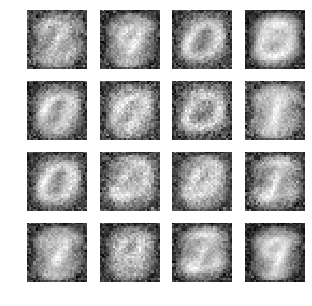

In [326]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(tf.reshape(model.sample(eps = tf.random.normal(shape = (1,5))),(28,28)),cmap="gray")
    plt.axis('off')
plt.show()

In [320]:
model.save_weights("/home/wcasazza/Documents/vaecit/scripts/mnist_test_weights.h5")